In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import plotly.graph_objects as go
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

from tqdm.auto import tqdm
from loguru import logger

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#####################
## UNet Components ##
#####################

from ddpm_components import DoubleConv, Down, SelfAttention, Up

###############
## Utilities ##
###############

from utils import get_data, create_diffusion_animation

In [2]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_dim=256, device=device):
        super().__init__()
        self.device = device
        self.time_dim = time_dim

        # Initial Conv (no size change)
        self.initial_conv = DoubleConv(in_channels, 24)
        
        # Encoder (Down) - each Down has MaxPool2d that halves spatial size
        self.down1 = Down(24, 48)              # 128 -> 64, NO SA (too expensive)
        self.down2 = Down(48, 96)              # 64 -> 32
        self.sa2 = SelfAttention(96, 32)       # spatial size: 32x32
        self.down3 = Down(96, 96)              # 32 -> 16
        self.sa3 = SelfAttention(96, 16)       # spatial size: 16x16
        
        # Bottle-neck (no size change) - reduced from 256 to 192
        self.bot1 = DoubleConv(96, 192)        # spatial size: 16x16
        self.bot2 = DoubleConv(192, 192)       # spatial size: 16x16
        self.bot3 = DoubleConv(192, 96)        # spatial size: 16x16
        
        # Decoder (Up) - each Up has Upsample that doubles spatial size
        self.up1 = Up(192, 48)                 # 16 -> 32 (concat with x3: 96ch)
        self.sa4 = SelfAttention(48, 32)       # spatial size: 32x32
        self.up2 = Up(96, 24)                  # 32 -> 64 (concat with x2: 48ch), NO SA
        self.up3 = Up(48, 24)                  # 64 -> 128 (concat with x1: 24ch), NO SA
        
        # Out Conv
        self.out_conv = nn.Conv2d(24, out_channels, kernel_size=1)
        
    def pos_encoding(self, t, channels):
        inv_freq = 1. / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
    
    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        
        # Encoder (Down path)
        x1 = self.initial_conv(x)      # 128x128, 24 ch
        x2 = self.down1(x1, t)         # 64x64, 48 ch (no SA - too expensive)
        x3 = self.down2(x2, t)         # 32x32, 96 ch
        x3 = self.sa2(x3)              # 32x32, 96 ch
        x4 = self.down3(x3, t)         # 16x16, 96 ch
        x4 = self.sa3(x4)              # 16x16, 96 ch
        
        # Bottle-neck
        x4 = self.bot1(x4)             # 16x16, 192 ch
        x4 = self.bot2(x4)             # 16x16, 192 ch
        x4 = self.bot3(x4)             # 16x16, 96 ch
        
        # Decoder (Up path)
        x = self.up1(x4, x3, t)        # 32x32, 48 ch
        x = self.sa4(x)                # 32x32, 48 ch
        x = self.up2(x, x2, t)         # 64x64, 24 ch (no SA - too expensive)
        x = self.up3(x, x1, t)         # 128x128, 24 ch (no SA - too expensive)
        out = self.out_conv(x)         # 128x128, 3 ch
        return out


# Test the parameter count
model = UNet().to(device=device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 3,319,443


In [3]:
###################
## Flower Images ##
###################

import gc
gc.collect()
torch.cuda.empty_cache()

from datasets import load_dataset
flowers = load_dataset(path="nkirschi/oxford-flowers", split="test")
flowers = flowers['image']

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 1 | Loss: 0.8955067721280184 | Current LR: 0.0002


Sampling: 0it [00:00, ?it/s]

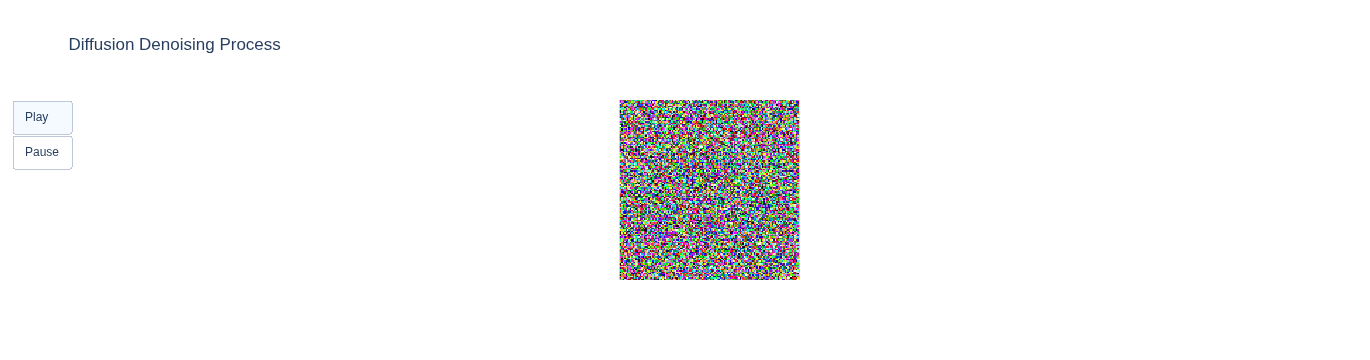

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 1000 | Loss: 0.021646111610938202 | Current LR: 0.0002


Sampling: 0it [00:00, ?it/s]

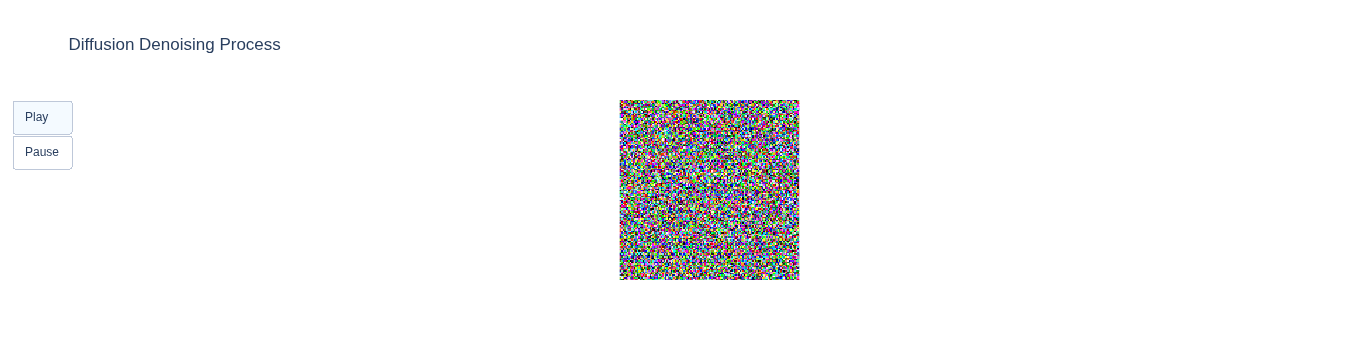

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 2000 | Loss: 0.018996273844756863 | Current LR: 0.00016


Sampling: 0it [00:00, ?it/s]

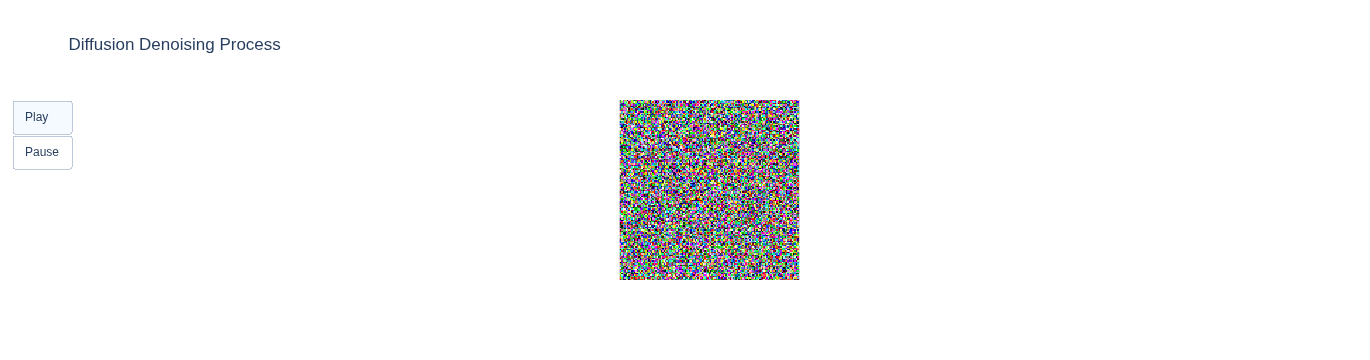

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 3000 | Loss: 0.0169670603830706 | Current LR: 0.00010240000000000002


Sampling: 0it [00:00, ?it/s]

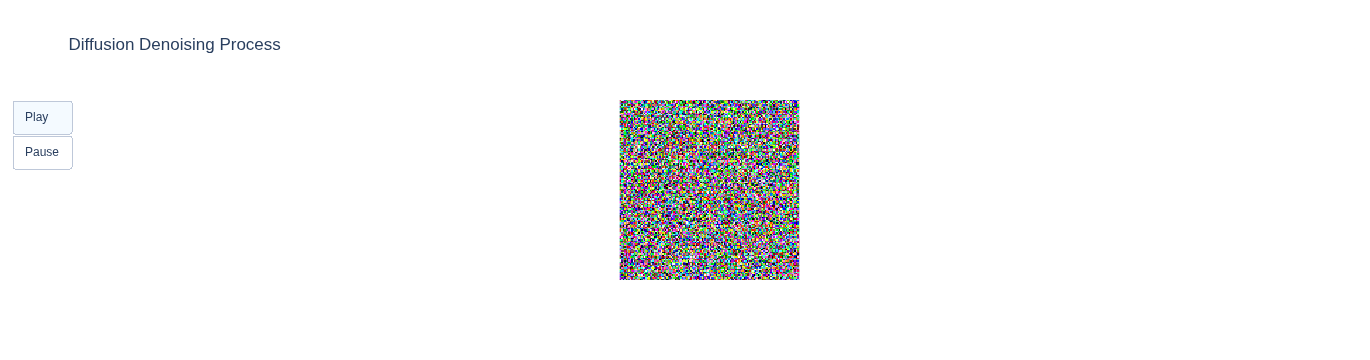

In [ ]:
####################
## Trainning loop ##
####################

IMG_SIZE = 128
BATCH_SIZE = 48

torch.manual_seed(42)
model = UNet().to(device=device)

#-------
## Train
#-------

from ddpm_components import train

train(model=model, data=flowers, epochs=4000, img_size=IMG_SIZE, batch_size=BATCH_SIZE, report_interval=1000, visualize=True)